In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from torchinfo import summary
import argparse
import time
import os
from model import LSTMModel, CNN_LSTM, DSTNET, LSTMNet

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
# parser = argparse.ArgumentParser(description='Add these argument for training')
# parser.add_argument('--dir', default='results', help='directory for saving trianed mode')
# parser.add_argument('--feature', required= True)

# parser.add_argument('--lr', default=0.005, help='learning rate')
# parser.add_argument('--epochs', default=10, help='epoch number')
# parser.add_argument('--batch_size', default=32)
# args = parser.parse_args()

# ## Set parameter for the model
# directory = args.dir                # directory for saving model
# batch_size = int(args.batch_size)   # batch size
# learning_rate = float(args.lr)
# num_epochs = int(args.epochs)

### **Data Processing**

In [4]:
data = pd.read_csv('data/solar_wind_parameters_data_1_hourly_all.csv')
print(data.shape)
# data = data.drop(columns=['Unnamed: 0','Timestamp'])

data.head()

(212088, 15)


,Unnamed: 0,Timestamp,YEAR,DOY,HR,Scalar_B,BX_GSE_GSM,BY_GSE,BZ_GSE,BY_GSM,BZ_GSM,Proton_Density,SW_Plasma_Temperature,SW_Plasma_Speed,Dst-index
0,0,1999-1-0,1999,1,0,6.792,-1.686,2.710,5.118,1.284,5.650,6.070,81042.0,415.28,-7.0
1,1,1999-1-1,1999,1,1,6.884,-4.513,0.390,3.240,-0.361,3.255,7.027,90525.0,400.50,-4.0
2,2,1999-1-2,1999,1,2,7.073,-3.813,-0.826,4.949,-1.808,4.681,6.793,88927.0,405.24,-4.0
3,3,1999-1-3,1999,1,3,6.644,-3.535,1.860,0.244,1.753,0.515,7.129,104190.0,413.07,-8.0
4,4,1999-1-4,1999,1,4,6.645,-3.082,1.953,2.664,1.730,2.866,6.963,101510.0,415.57,-8.0


In [5]:
features = ['Scalar_B', 'BX_GSE_GSM', 'BY_GSE', 'BZ_GSE', 'BY_GSM', 'BZ_GSM', 'Proton_Density', 'SW_Plasma_Temperature', 'SW_Plasma_Speed']
target = ['Dst-index']

# Select the features and target
data = data[features + target]
# data.head()
X = data[features].values
y = data[target].values

print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')

# Normalize the data
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21, shuffle=False)

# Scale X
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Scale y (if regression)
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# merge X and y
train_data = np.concatenate((X_train_scaled, y_train_scaled), axis=1)
test_data = np.concatenate((X_test_scaled, y_test_scaled), axis=1)

# Split the data into sequences
def sequence(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :-1]) # all columns except the last
        y.append(data[i+seq_length, -1])  # target is the last column
        # print(f'X:{np.array(X)}, Y:{np.array(y)}')
    return np.array(X), np.array(y)

SEQ_LENGTH = 24
X_train, y_train = sequence(train_data, SEQ_LENGTH)
X_test, y_test = sequence(test_data, SEQ_LENGTH)

X shape: (212088, 9)
y shape: (212088, 1)


In [6]:
test_df = pd.DataFrame(test_data, columns=features + target)
test_df.head()

,Scalar_B,BX_GSE_GSM,BY_GSE,BZ_GSE,BY_GSM,BZ_GSM,Proton_Density,SW_Plasma_Temperature,SW_Plasma_Speed,Dst-index
0,0.062001,0.495558,0.465603,0.634731,0.545103,0.596063,0.027044,0.076529,0.257635,0.505682
1,0.062266,0.506122,0.482973,0.621360,0.562675,0.584881,0.028425,0.069880,0.258177,0.505682
2,0.063018,0.543825,0.497848,0.609591,0.577846,0.574967,0.027859,0.059386,0.280887,0.517045
3,0.062503,0.515074,0.476367,0.611542,0.557246,0.575339,0.032012,0.067318,0.259582,0.511364
4,0.066351,0.511915,0.495281,0.624130,0.574022,0.586994,0.030919,0.047238,0.253533,0.517045


In [7]:

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

print(f'X_train_tensor shape: {X_train_tensor.shape}')
print(f'y_train_tensor shape: {y_train_tensor.shape}')
print(f'X_test_tensor shape: {X_test_tensor.shape}')
print(f'y_test_tensor shape: {y_test_tensor.shape}')

# Create a DataLoader
train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32

train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

X_train_tensor shape: torch.Size([148437, 24, 9])
y_train_tensor shape: torch.Size([148437])
X_test_tensor shape: torch.Size([63603, 24, 9])
y_test_tensor shape: torch.Size([63603])


### **Model**

In [8]:

learning_rate = 0.0001
directory = 'results/run7'

input_size = len(features)
hidden_layer_size = 64
output_size = 1
model = CNN_LSTM(
    input_size=input_size,
    hidden_size=hidden_layer_size,
    output_size=output_size,
    num_layers=2  # Explicitly set num_layers
).to(device)
# print(f'Model: {model} input_size: {input_size}, hidden_layer_size: {hidden_layer_size}, output_size: {output_size}')
print(summary(model, input_size=(batch_size, SEQ_LENGTH, input_size)))

criterion = nn.MSELoss()


Layer (type:depth-idx)                   Output Shape              Param #
CNN_LSTM                                 [32, 1]                   --
├─Conv1d: 1-1                            [32, 32, 24]              896
├─LSTM: 1-2                              [32, 24, 64]              58,368
├─Linear: 1-3                            [32, 1]                   65
Total params: 59,329
Trainable params: 59,329
Non-trainable params: 0
Total mult-adds (M): 45.52
Input size (MB): 0.03
Forward/backward pass size (MB): 0.59
Params size (MB): 0.24
Estimated Total Size (MB): 0.86


### **Training Loop**

In [9]:

num_epochs = 100
accumulation_steps = 4  # Accumulate gradients for larger effective batch size
scaler = torch.amp.GradScaler("cuda")  # For mixed precision training

from torch.optim.lr_scheduler import OneCycleLR

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.01)
total_steps = len(train_loader) * num_epochs

scheduler = OneCycleLR(
    optimizer,
    max_lr=1e-3,
    total_steps=total_steps,
    pct_start=0.1,  # Warmup for 10% of training
    div_factor=25,  # Initial lr = max_lr/25
    final_div_factor=100,  # Less aggressive final lr reduction
    anneal_strategy='cos'  # Cosine annealing
)

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(f'./{directory}/runs')

def check_data_statistics(loader):
    all_data = []
    for X, _ in loader:
        all_data.append(X.cpu().numpy())
    all_data = np.concatenate(all_data, axis=0)
    
    print("Data Statistics:")
    print(f"Mean: {np.mean(all_data):.4f}")
    print(f"Std: {np.std(all_data):.4f}")
    print(f"Min: {np.min(all_data):.4f}")
    print(f"Max: {np.max(all_data):.4f}")

check_data_statistics(train_loader)
check_data_statistics(test_loader)


# Training Loop
train_losses = []
test_losses = []
train_loss = 0.0
test_loss = 0.0

best_loss = float('inf')
patience_counter = 0
patience = 15

best_epoch = 0
rec = []

patience = 15
patience_counter = 0

for epoch in range(num_epochs):
    start = time.time()
    model.train()
    running_loss = 0.0
    optimizer.zero_grad()

    for i, (X_train, y_train) in enumerate(train_loader):
        with torch.amp.autocast("cuda"):
            y_pred = model(X_train)
            y_pred = y_pred.view(-1)
            loss = criterion(y_pred, y_train)
            loss = loss / accumulation_steps
        
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        writer.add_scalar('Gradient Norm', grad_norm, epoch)
        writer.add_scalar('Learning Rate', scheduler.get_last_lr()[0], epoch)
        writer.add_scalar('Train Loss', train_loss, epoch)
        writer.add_scalar('Test Loss', test_loss, epoch)
        
        if (i + 1) % accumulation_steps == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)  # First optimizer step
            scheduler.step()        # Then scheduler step
            scaler.update()
            optimizer.zero_grad()
        
        running_loss += loss.item() * accumulation_steps
    
    end = time.time()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Test the model
    test_loss = 0.0
    model.eval()
    with torch.no_grad():
        for X_test, y_test in test_loader:
            y_pred = model(X_test)
            y_pred = y_pred.view(-1)
            loss = criterion(y_pred, y_test)
            test_loss += loss.item()
    
    test_loss = test_loss / len(test_loader)
    test_losses.append(test_loss)

    # Early stopping
    if test_loss < best_loss:  # Remove the 0.995 multiplier
        improvement = (best_loss - test_loss) / best_loss * 100
        best_loss = test_loss
        patience_counter = 0
        
        if improvement > 0.1:  # Only save if improvement is significant (0.1%)
            print(f"Model improved by {improvement:.2f}% from {best_loss:.4f} to {test_loss:.4f}. Saving model...")
            best_epoch = epoch + 1
            
            checkpoint = {
                'epoch': best_epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'loss': best_loss,
                'input_size': model.input_size,
                'hidden_size': model.hidden_size,
                'num_layers': model.num_layers,
            }
            torch.save(checkpoint, f'./{directory}/model{round(best_loss*10000)}.pth')
            torch.save(checkpoint, f'./{directory}/best_model.pth')
    else:
        patience_counter += 1

    if patience_counter > patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

    # Adjust learning rate
    # scheduler.step(test_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Time: {end-start:.2f} sec")

    if epoch % 5 == 0:  # Plot every 5 epochs
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Train Loss')
        plt.plot(test_losses, label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Progress')
        plt.legend()
        plt.grid(True)
        plt.savefig(f'./{directory}/learning_curve.png')
        plt.close()    

    # Record results
    rec.append({
        'epoch': epoch + 1,
        'train_loss': train_loss,
        'test_loss': test_loss,
    })

# Write results to csv
df = pd.DataFrame(rec)
df.to_csv(f'{directory}/results.csv', index=False)

print(f"Finihsed training after {num_epochs} epochs. Best loss: {best_loss:.4f} at epoch {best_epoch}")

Data Statistics:
Mean: 0.3524
Std: 0.2366
Min: 0.0000
Max: 1.0000
Data Statistics:
Mean: 0.3492
Std: 0.2373
Min: 0.0012
Max: 0.8318
Epoch [1/100], Train Loss: 0.0602, Test Loss: 0.0103, Time: 7.04 sec
Model improved by 18.47% from 0.0084 to 0.0084. Saving model...
Epoch [2/100], Train Loss: 0.0109, Test Loss: 0.0084, Time: 6.91 sec
Epoch [3/100], Train Loss: 0.0103, Test Loss: 0.0087, Time: 7.06 sec
Model improved by 1.36% from 0.0083 to 0.0083. Saving model...
Epoch [4/100], Train Loss: 0.0100, Test Loss: 0.0083, Time: 6.96 sec
Model improved by 10.50% from 0.0074 to 0.0074. Saving model...
Epoch [5/100], Train Loss: 0.0097, Test Loss: 0.0074, Time: 6.81 sec
Model improved by 7.65% from 0.0068 to 0.0068. Saving model...
Epoch [6/100], Train Loss: 0.0092, Test Loss: 0.0068, Time: 6.81 sec
Epoch [7/100], Train Loss: 0.0089, Test Loss: 0.0083, Time: 6.83 sec
Epoch [8/100], Train Loss: 0.0089, Test Loss: 0.0078, Time: 6.76 sec
Epoch [9/100], Train Loss: 0.0087, Test Loss: 0.0088, Time: 6.

### **Test the Result**

Load Checkpoint (Optional)

In [10]:
# Load the trained model
# path = 'results/run4/best_model.pth'
# checkpoint = torch.load(f'{path}', map_location=device)
# print(checkpoint.keys())

# # Recreate the model
# model = LSTMModel(checkpoint['input_size'], checkpoint['hidden_size'], output_size=1).to(device)

# Load the model weights
# model.load_state_dict(checkpoint['model_state_dict'])
# model.eval()  # Set to evaluation mode

# print("Model loaded successfully!")

In [11]:

# Predict
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    # print(f'y_pred:{y_pred.shape} {y_pred}')

# Convert true values to NumPy
y_test = y_test_tensor.cpu().numpy()

# Fix the shape by flattening y_pred
y_pred = y_pred.cpu().numpy().flatten()
# print(f'y_pred:{y_pred.shape} {y_pred}')

# Inverse transform the scaled values
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_original = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()

print(f'y_pred_original:{y_pred_original.shape} {y_pred_original}')

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test_original, y_pred_original)
print(f'MSE: {mse:.2f}')


y_pred_original:(63603,) [-12.613741   -9.948031   -8.051228  ...  -7.63223    -7.408721
  -7.1590805]
MSE: 82.31


### Plot

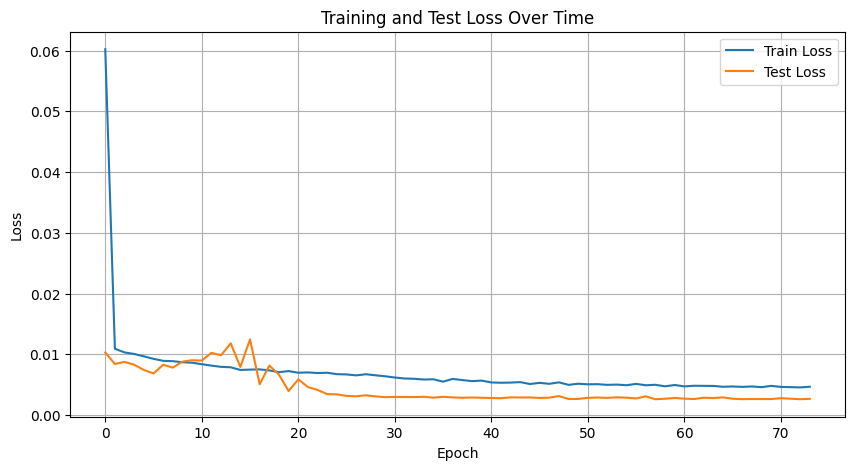

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Time')
plt.legend()
plt.grid(True)
plt.show()

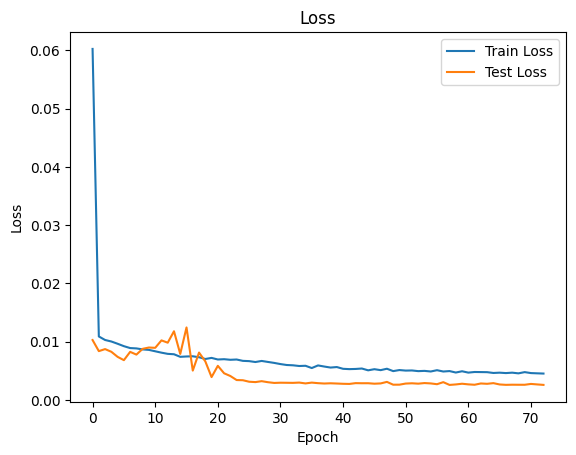

In [13]:
# Plot loss
df = pd.read_csv(f'{directory}/results.csv')
plt.plot(df['train_loss'], label='Train Loss')
plt.plot(df['test_loss'], label='Test Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f'{directory}/loss.png')
plt.show()

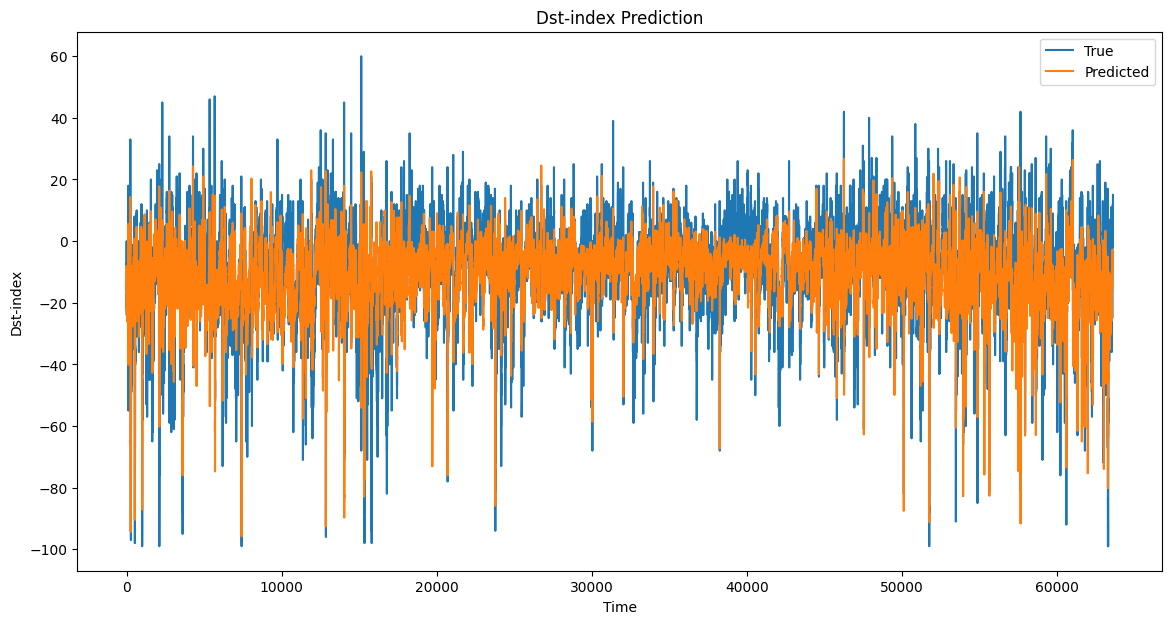

In [14]:
# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(y_test_original, label='True')
plt.plot(y_pred_original, label='Predicted')
plt.title('Dst-index Prediction')
plt.xlabel('Time')
plt.ylabel('Dst-index')
plt.legend()
plt.savefig(f'{directory}/prediction.png')
plt.show()